# Import Packages and Global Params

In [41]:
####################################
#  Amy Edwards
#  CSC 540 
#  Final Project
#  March 18, 2019
#  Code based on Scikit Template 
#  created by Casey Bennett 2018, 
#  www.CaseyBennett.com
#####################################

import sys
import csv
import math
import numpy as np
from operator import itemgetter
import time
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.externals import joblib
from sklearn.feature_selection import RFE, VarianceThreshold, SelectFromModel
from sklearn.feature_selection import SelectKBest, mutual_info_regression, mutual_info_classif, chi2
from sklearn import metrics
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import KBinsDiscretizer, scale, LabelEncoder
from sklearn.model_selection import GridSearchCV

#Handle annoying warnings
import warnings, sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)


########################
#
#   Global parameters
#
########################

target_idx= 0                                       #Index of Target variable
cross_val=1                                        #Control Switch for CV
norm_target=1                                       #Normalize target switch
norm_features=0                                     #Normalize feature switch
binning=1                                           #Control Switch for Bin Target
bin_cnt=2                                           #If bin target, this sets number of classes
feat_select=1                                       #Control Switch for Feature Selection
fs_type=2                                         #Feature Selection type (1=Stepwise Backwards Removal, 2=Wrapper Select, 3=Univariate Selection)
lv_filter=0                                         #Control switch for low variance filter on features
feat_start=1                                        #Start column of features
k_cnt=5                                             #Number of 'Top k' best ranked features to select, only applies for fs_types 1 and 3

#Set global model parameters
rand_st=0                                           #Set Random State variable for randomizing splits on runs




# Import Data

In [42]:

#####################
#
#    Load Data
#
#####################

file1= csv.reader(open('regress_departure.csv'), delimiter=',', quotechar='"')

#Read Header Line
header=next(file1)            

#Read data
data=[]
target=[]
for row in file1:
    #Load Target
    if row[target_idx]=='':                         #If target is blank, skip row                       
        continue
    else:
        target.append(float(row[target_idx]))       #If pre-binned class, change float to int

    #Load row into temp array, cast columns  
    temp=[]
                 
    for j in range(feat_start,len(header)):
        if j == target_idx:
            continue
        if row[j]=='':
            temp.append(float())
        else:
            temp.append(float(row[j]))

    #Load temp into Data array
    data.append(temp)
  
#Test Print
print(header)
print(len(target),len(data))
'''for i in range(10):
    print(target[i])
    print(data[i])'''
print('\n')

data_np=np.asarray(data)
target_np=np.asarray(target)



['target', 'DISTANCE', 'DIVERTED', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4', 'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'DAY_OF_WEEK_7', 'AIRLINE_AS', 'AIRLINE_B6', 'AIRLINE_DL', 'AIRLINE_EV', 'AIRLINE_F9', 'AIRLINE_HA', 'AIRLINE_MQ', 'AIRLINE_NK', 'AIRLINE_OO', 'AIRLINE_UA', 'AIRLINE_US', 'AIRLINE_VX', 'AIRLINE_WN', 'ORIGIN_AIRPORT_ATL', 'ORIGIN_AIRPORT_AUS', 'ORIGIN_AIRPORT_BDL', 'ORIGIN_AIRPORT_BNA', 'ORIGIN_AIRPORT_BOS', 'ORIGIN_AIRPORT_BUR', 'ORIGIN_AIRPORT_BWI', 'ORIGIN_AIRPORT_CLE', 'ORIGIN_AIRPORT_CLT', 'ORIGIN_AIRPORT_CMH', 'ORIGIN_AIRPORT_CVG', 'ORIGIN_AIRPORT_DAL', 'ORIGIN_AIRPORT_DCA', 'ORIGIN_AIRPORT_DEN', 'ORIGIN_AIRPORT_DFW', 'ORIGIN_AIRPORT_DTW', 'ORIGIN_AIRPORT_EWR', 'ORIGIN_AIRPORT_FLL', 'ORIGIN_AIRPORT_HNL', 'ORIGIN_AIRPORT_HOU', 'ORIGIN_AIRPORT_IAD', 'ORIGIN_AIRPORT_IAH', 'ORIGIN_AIRPORT_IND', 'ORIGIN_AIRPORT_JAX', 'ORIGIN_AIRPORT_JFK', 'ORIGIN

# Preprocessing and Feature Selection

In [43]:
############################
#
# Preprocess data
#
###########################


if norm_target==1:
    #Target normalization for continuous values
    target_np=scale(target_np)

if norm_features==1:
    #Feature normalization for continuous values
    data_np=scale(data_np)


#############################
#
# Feature Selection
#
#############################


#Feature Selection
if feat_select==1:
    '''Three steps:
       1) Run Feature Selection
       2) Get lists of selected and non-selected features
       3) Filter columns from original dataset
       '''
    
    print('--FEATURE SELECTION ON--', '\n')
    
    ##1) Run Feature Selection #######
    if fs_type==1:
        #stepwise backward
        rgr = RandomForestRegressor(n_estimators=500, max_depth=None, min_samples_split=3, criterion='mse', random_state=None)
        sel = RFE(rgr, n_features_to_select=k_cnt, step=.1)
        print('Stepwise Recursive Backwards - Random Forest: ')
            
        fit_mod=sel.fit(data_np, target_np)
        print(sel.ranking_)
        sel_idx=fit_mod.get_support()      

    if fs_type==2:
        #Wrapper Select via model
    
        rgr =GradientBoostingRegressor(loss = 'ls', n_estimators = 200, learning_rate = 0.03, max_depth = 10, min_samples_split = 500, max_features = 'auto',random_state = rand_st,subsample = 0.8)
        sel = SelectFromModel(rgr, prefit=False, threshold='mean', max_features=None)
        print ('Wrapper Select - Random Forest: ')
            
        fit_mod=sel.fit(data_np, target_np)    
        sel_idx=fit_mod.get_support()

    if fs_type==3:       
    ######Only work if the Target is continuous###########
        #Univariate Feature Selection - Mutual Info Regression
        sel=SelectKBest(mutual_info_regression, k=k_cnt)
        fit_mod=sel.fit(data_np, target_np)
        print ('Univariate Feature Selection - Mutual Info: ')
        sel_idx=fit_mod.get_support()

        #Print ranked variables out sorted
        temp=[]
        scores=fit_mod.scores_
        for i in range(feat_start, len(header)):            
            temp.append([header[i], float(scores[i-feat_start])])

        print('Ranked Features')
        temp_sort=sorted(temp, key=itemgetter(1), reverse=True)
        for i in range(len(temp_sort)):
            print(i, temp_sort[i][0], ':', temp_sort[i][1])
        print('\n')

    ##2) Get lists of selected and non-selected features (names and indexes) #######
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(data_np[0])):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(header[i+feat_start])
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)
    print('Selected', temp)
    print('Features (total/selected):', len(data_np[0]), len(temp))
    print('\n')
            
                
    ##3) Filter selected columns from original dataset #########
    header = header[0:feat_start]
    for field in temp:
        header.append(field)
    data_np = np.delete(data_np, temp_del, axis=1)                                 #Deletes non-selected features by index)



--FEATURE SELECTION ON-- 

Wrapper Select - Random Forest: 
Selected ['DISTANCE', 'DIVERTED', 'MONTH_2', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4', 'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'DAY_OF_WEEK_7', 'AIRLINE_AS', 'AIRLINE_B6', 'AIRLINE_DL', 'AIRLINE_F9', 'AIRLINE_HA', 'AIRLINE_NK', 'AIRLINE_UA', 'AIRLINE_US', 'AIRLINE_WN', 'ORIGIN_AIRPORT_ATL', 'ORIGIN_AIRPORT_AUS', 'ORIGIN_AIRPORT_CVG', 'ORIGIN_AIRPORT_JFK', 'ORIGIN_AIRPORT_OGG', 'ORIGIN_AIRPORT_ORD', 'ORIGIN_AIRPORT_PIT', 'ORIGIN_AIRPORT_SFO', 'DESTINATION_AIRPORT_DFW', 'DESTINATION_AIRPORT_EWR', 'DESTINATION_AIRPORT_HNL', 'DESTINATION_AIRPORT_JFK', 'DESTINATION_AIRPORT_LGA', 'DESTINATION_AIRPORT_ORD', 'DESTINATION_AIRPORT_SFO', 'SCHEDULED_DEPARTURE_2', 'SCHEDULED_DEPARTURE_3', 'SCHEDULED_DEPARTURE_4']
Features (total/selected): 149 44




# Train / Test Split

In [44]:
##################################
#
#     Train SciKit Models
#
##################################

print('--ML Model Output--', '\n')

# Test/Train split
data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)


--ML Model Output-- 



# Various Models to test

In [31]:
#Setup Crossval regression scorers
scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 
#SciKit Gradient Boosting - Cross Val
start_ts=time.time()
#model= GradientBoostingRegressor(loss = 'ls', n_estimators = 200, learning_rate = 0.03, max_depth = 10, min_samples_split = 500, max_features = 'auto',random_state = rand_st,subsample = 0.8)
#model = Ridge(alpha=1, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=rand_st)
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,random_state=rand_st, loss='ls')
scores = cross_validate(model, data_np, y = target_np, scoring = scorers, cv = 5)
scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       #Turns negative MSE scores into RMSE
scores_Expl_Var = scores['test_expl_var']
print("Gradient Boosting RMSE: %0.4f (+/- %0.4f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Gradient Boosting Expl Var: %0.4f (+/- %0.4f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)

Gradient Boosting RMSE: 81.5895 (+/- 44.4010)
Gradient Boosting Expl Var: -0.3288 (+/- 0.8097)
CV Runtime: 212.448016166687


In [32]:
#SciKit Neural Network - Cross Val
start_ts=time.time()
model_NN=MLPRegressor(activation='logistic', solver = 'lbfgs', max_iter= 1000, hidden_layer_sizes = (10,), alpha = 0.0001, random_state = rand_st)
scores = cross_validate(model_NN, data_np, y = target_np, scoring = scorers, cv = 5)
scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])            #Turns negative MSE scores into RMSE                                             
scores_Expl_Var = scores['test_expl_var']
print("Neural Net RMSE: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std()* 2)))
print("Neural Net Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)

Neural Net RMSE: 83.22 (+/- 44.03)
Neural Net Expl Var: -0.15 (+/- 0.57)
CV Runtime: 27.30138325691223


In [27]:
start_ts=time.time()
model_Linear = LinearRegression()
scores = cross_validate(model_Linear, data_np, target_np, scoring=scorers, cv=5)
scores_RMSE = np.asarray([math.sqrt(-x) for x in scores ['test_Neg_MSE']]) #Turns negative MSE scores into RMSE
scores_Expl_Var = scores['test_expl_var']
print("Linear RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Linear Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)

Linear RMSE:: 81.31 (+/- 44.23)
Linear Expl Var: -0.60 (+/- 1.46)
CV Runtime: 1.8268680572509766


In [33]:
#SciKit Random Forest Regressor - Cross Val
start_ts=time.time()
model_Forest = RandomForestRegressor(n_estimators = 100, max_features = 0.33, max_depth = None, random_state = rand_st, min_samples_split = 3) 
scores = cross_validate(model_Forest, data_np, y = target_np, scoring = scorers, cv = 5)
scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       #Turns negative MSE scores into RMSE
scores_Expl_Var = scores['test_expl_var']
print("Random Forest RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Random Forest Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)

Random Forest RMSE:: 84.55 (+/- 41.27)
Random Forest Expl Var: -2.97 (+/- 7.00)
CV Runtime: 456.64047718048096


In [30]:
#SciKit Decision Tree Regressor - Cross Val
start_ts=time.time()
model_Decision = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None, random_state=rand_st)
scores = cross_validate(model_Decision, data_np, target_np, scoring=scorers, cv=5)
scores_RMSE = np.asarray([math.sqrt(-x) for x in scores ['test_Neg_MSE']]) #Turns negative MSE scores into RMSE
scores_Expl_Var = scores['test_expl_var']
print("Decision Tree RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Decision Tree Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)

Decision Tree RMSE:: 110.70 (+/- 26.56)
Decision Tree Expl Var: -16.88 (+/- 39.10)
CV Runtime: 20.465000867843628


In [37]:
#SciKit Bagging Regressor
start_ts=time.time()
dgr = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None, random_state=rand_st) 
bag = BaggingRegressor(dgr, max_samples = 0.6, random_state = rand_st)
scores = cross_validate(bag, data_np, target_np, scoring=scorers, cv=5)

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores ['test_Neg_MSE']]) #Turns negative MSE scores into RMSE
scores_Expl_Var = scores['test_expl_var']
print("Decision Bag Tree RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Decision Bag Tree Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)

Decision Bag Tree RMSE:: 87.23 (+/- 40.45)
Decision Bag Tree Expl Var: -4.18 (+/- 9.80)
CV Runtime: 82.01302599906921


## Another round of feature selection using extra trees

In [39]:
model = ExtraTreesRegressor() 
model.fit(data_train, target_train) 
print(model.feature_importances_)

/Users/amyeds/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.04650333 0.00256643 0.016071   0.0208238  0.0178605  0.02049037
 0.01691452 0.01302015 0.01906563 0.00916417 0.00767533 0.01762142
 0.00723327 0.03142324 0.0392198  0.03657404 0.03627935 0.0365329
 0.04053752 0.0027948  0.00325186 0.014286   0.00360874 0.00209715
 0.0011153  0.00196672 0.0031191  0.0061848  0.00364134 0.00289269
 0.00224429 0.00841067 0.00732292 0.00370526 0.0016891  0.00397167
 0.00619285 0.00147421 0.00458455 0.00570226 0.00453142 0.00242122
 0.00188086 0.0026109  0.00555695 0.00875351 0.00660212 0.00362439
 0.00573204 0.00520841 0.00165142 0.00154004 0.0039404  0.00493459
 0.00292926 0.00256712 0.00415882 0.00991482 0.00748506 0.00529732
 0.00285585 0.00899274 0.00275343 0.0044049  0.00321344 0.00469238
 0.00425977 0.00185467 0.00156151 0.00164956 0.00918085 0.00262019
 0.00278757 0.00543741 0.00520149 0.00336781 0.00320468 0.0026376
 0.00501193 0.00309475 0.00422053 0.00583082 0.00174037 0.0057121
 0.00305849 0.00265632 0.00368966 0.00387999 0.00553067 0.0108378

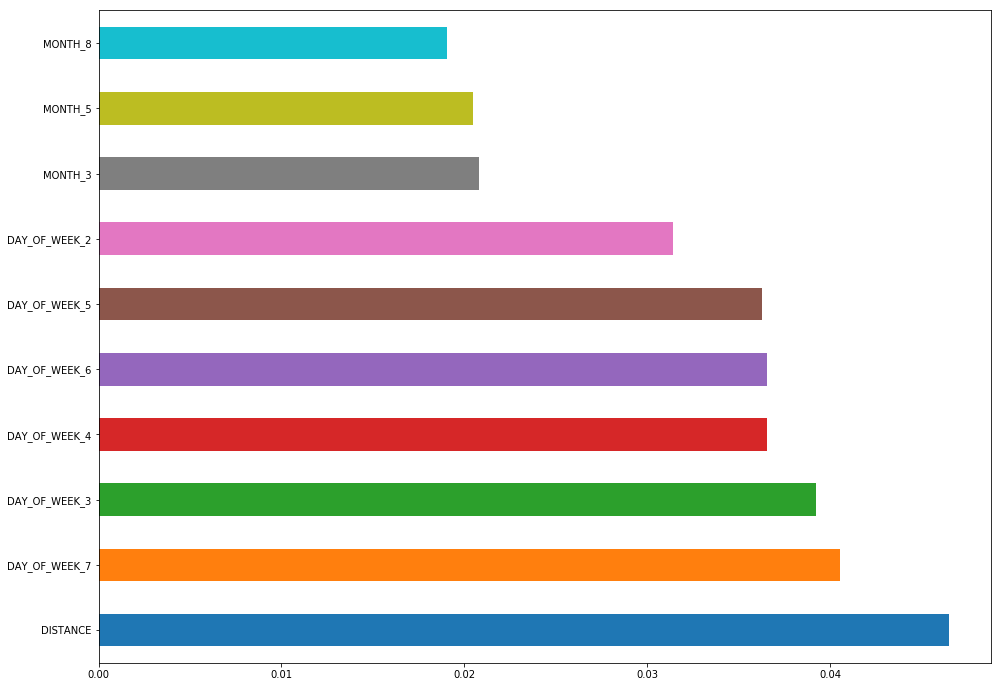

In [40]:
#plot graph of feature importances for better visualization 
feat_importances = pd.Series(model.feature_importances_, index=['DISTANCE', 'DIVERTED', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4', 'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'DAY_OF_WEEK_7', 'AIRLINE_AS', 'AIRLINE_B6', 'AIRLINE_DL', 'AIRLINE_EV', 'AIRLINE_F9', 'AIRLINE_HA', 'AIRLINE_MQ', 'AIRLINE_NK', 'AIRLINE_OO', 'AIRLINE_UA', 'AIRLINE_US', 'AIRLINE_VX', 'AIRLINE_WN', 'ORIGIN_AIRPORT_ATL', 'ORIGIN_AIRPORT_AUS', 'ORIGIN_AIRPORT_BDL', 'ORIGIN_AIRPORT_BNA', 'ORIGIN_AIRPORT_BOS', 'ORIGIN_AIRPORT_BUR', 'ORIGIN_AIRPORT_BWI', 'ORIGIN_AIRPORT_CLE', 'ORIGIN_AIRPORT_CLT', 'ORIGIN_AIRPORT_CMH', 'ORIGIN_AIRPORT_CVG', 'ORIGIN_AIRPORT_DAL', 'ORIGIN_AIRPORT_DCA', 'ORIGIN_AIRPORT_DEN', 'ORIGIN_AIRPORT_DFW', 'ORIGIN_AIRPORT_DTW', 'ORIGIN_AIRPORT_EWR', 'ORIGIN_AIRPORT_FLL', 'ORIGIN_AIRPORT_HNL', 'ORIGIN_AIRPORT_HOU', 'ORIGIN_AIRPORT_IAD', 'ORIGIN_AIRPORT_IAH', 'ORIGIN_AIRPORT_IND', 'ORIGIN_AIRPORT_JAX', 'ORIGIN_AIRPORT_JFK', 'ORIGIN_AIRPORT_LAS', 'ORIGIN_AIRPORT_LAX', 'ORIGIN_AIRPORT_LGA', 'ORIGIN_AIRPORT_MCI', 'ORIGIN_AIRPORT_MCO', 'ORIGIN_AIRPORT_MDW', 'ORIGIN_AIRPORT_MIA', 'ORIGIN_AIRPORT_MKE', 'ORIGIN_AIRPORT_MSP', 'ORIGIN_AIRPORT_MSY', 'ORIGIN_AIRPORT_OAK', 'ORIGIN_AIRPORT_OGG', 'ORIGIN_AIRPORT_ONT', 'ORIGIN_AIRPORT_ORD', 'ORIGIN_AIRPORT_PBI', 'ORIGIN_AIRPORT_PDX', 'ORIGIN_AIRPORT_PHL', 'ORIGIN_AIRPORT_PHX', 'ORIGIN_AIRPORT_PIT', 'ORIGIN_AIRPORT_RDU', 'ORIGIN_AIRPORT_RSW', 'ORIGIN_AIRPORT_SAN', 'ORIGIN_AIRPORT_SAT', 'ORIGIN_AIRPORT_SEA', 'ORIGIN_AIRPORT_SFO', 'ORIGIN_AIRPORT_SJC', 'ORIGIN_AIRPORT_SJU', 'ORIGIN_AIRPORT_SLC', 'ORIGIN_AIRPORT_SMF', 'ORIGIN_AIRPORT_SNA', 'ORIGIN_AIRPORT_STL', 'ORIGIN_AIRPORT_TPA', 'DESTINATION_AIRPORT_ATL', 'DESTINATION_AIRPORT_AUS', 'DESTINATION_AIRPORT_BDL', 'DESTINATION_AIRPORT_BNA', 'DESTINATION_AIRPORT_BOS', 'DESTINATION_AIRPORT_BUR', 'DESTINATION_AIRPORT_BWI', 'DESTINATION_AIRPORT_CLE', 'DESTINATION_AIRPORT_CLT', 'DESTINATION_AIRPORT_CMH', 'DESTINATION_AIRPORT_CVG', 'DESTINATION_AIRPORT_DAL', 'DESTINATION_AIRPORT_DCA', 'DESTINATION_AIRPORT_DEN', 'DESTINATION_AIRPORT_DFW', 'DESTINATION_AIRPORT_DTW', 'DESTINATION_AIRPORT_EWR', 'DESTINATION_AIRPORT_FLL', 'DESTINATION_AIRPORT_HNL', 'DESTINATION_AIRPORT_HOU', 'DESTINATION_AIRPORT_IAD', 'DESTINATION_AIRPORT_IAH', 'DESTINATION_AIRPORT_IND', 'DESTINATION_AIRPORT_JAX', 'DESTINATION_AIRPORT_JFK', 'DESTINATION_AIRPORT_LAS', 'DESTINATION_AIRPORT_LAX', 'DESTINATION_AIRPORT_LGA', 'DESTINATION_AIRPORT_MCI', 'DESTINATION_AIRPORT_MCO', 'DESTINATION_AIRPORT_MDW', 'DESTINATION_AIRPORT_MIA', 'DESTINATION_AIRPORT_MKE', 'DESTINATION_AIRPORT_MSP', 'DESTINATION_AIRPORT_MSY', 'DESTINATION_AIRPORT_OAK', 'DESTINATION_AIRPORT_OGG', 'DESTINATION_AIRPORT_ONT', 'DESTINATION_AIRPORT_ORD', 'DESTINATION_AIRPORT_PBI', 'DESTINATION_AIRPORT_PDX', 'DESTINATION_AIRPORT_PHL', 'DESTINATION_AIRPORT_PHX', 'DESTINATION_AIRPORT_PIT', 'DESTINATION_AIRPORT_RDU', 'DESTINATION_AIRPORT_RSW', 'DESTINATION_AIRPORT_SAN', 'DESTINATION_AIRPORT_SAT', 'DESTINATION_AIRPORT_SEA', 'DESTINATION_AIRPORT_SFO', 'DESTINATION_AIRPORT_SJC', 'DESTINATION_AIRPORT_SJU', 'DESTINATION_AIRPORT_SLC', 'DESTINATION_AIRPORT_SMF', 'DESTINATION_AIRPORT_SNA', 'DESTINATION_AIRPORT_STL', 'DESTINATION_AIRPORT_TPA', 'SCHEDULED_DEPARTURE_2', 'SCHEDULED_DEPARTURE_3', 'SCHEDULED_DEPARTURE_4']) 
plt.figure(figsize=(16, 12)) 
feat_importances.nlargest(10).plot(kind='barh') 
plt.savefig('regressionfeature_importance50.png', DPI = 600)

# Load Validation Data

In [7]:
#####################
#
#    Load Data
#
#####################

file2= csv.reader(open('regress_departure_validate.csv'), delimiter=',', quotechar='"')

#Read Header Line
header2=next(file2)            

#Read data
data2=[]
target2=[]
for row in file2:
    #Load Target
    if row[target_idx]=='':                         #If target is blank, skip row                       
        continue
    else:
        target2.append(float(row[target_idx]))       #If pre-binned class, change float to int

    #Load row into temp array, cast columns  
    temp2=[]
                 
    for j in range(feat_start,len(header2)):
        if j == target_idx:
            continue
        if row[j]=='':
            temp2.append(float())
        else:
            temp2.append(float(row[j]))

    #Load temp into Data array
    data2.append(temp2)
  
#Test Print
print(header2)
print(len(target2),len(data2))
'''for i in range(10):
    print(target[i])
    print(data[i])'''
print('\n')

data2_np=np.asarray(data2)
target2_np=np.asarray(target2)




['target', 'DISTANCE', 'DIVERTED', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4', 'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'DAY_OF_WEEK_7', 'AIRLINE_AS', 'AIRLINE_B6', 'AIRLINE_DL', 'AIRLINE_EV', 'AIRLINE_F9', 'AIRLINE_HA', 'AIRLINE_MQ', 'AIRLINE_NK', 'AIRLINE_OO', 'AIRLINE_UA', 'AIRLINE_US', 'AIRLINE_VX', 'AIRLINE_WN', 'ORIGIN_AIRPORT_ATL', 'ORIGIN_AIRPORT_AUS', 'ORIGIN_AIRPORT_BDL', 'ORIGIN_AIRPORT_BNA', 'ORIGIN_AIRPORT_BOS', 'ORIGIN_AIRPORT_BUR', 'ORIGIN_AIRPORT_BWI', 'ORIGIN_AIRPORT_CLE', 'ORIGIN_AIRPORT_CLT', 'ORIGIN_AIRPORT_CMH', 'ORIGIN_AIRPORT_CVG', 'ORIGIN_AIRPORT_DAL', 'ORIGIN_AIRPORT_DCA', 'ORIGIN_AIRPORT_DEN', 'ORIGIN_AIRPORT_DFW', 'ORIGIN_AIRPORT_DTW', 'ORIGIN_AIRPORT_EWR', 'ORIGIN_AIRPORT_FLL', 'ORIGIN_AIRPORT_HNL', 'ORIGIN_AIRPORT_HOU', 'ORIGIN_AIRPORT_IAD', 'ORIGIN_AIRPORT_IAH', 'ORIGIN_AIRPORT_IND', 'ORIGIN_AIRPORT_JAX', 'ORIGIN_AIRPORT_JFK', 'ORIGIN

# Fit on final model

In [18]:
rgr.fit(data2_np, target2_np)
scores_RMSE = math.sqrt(metrics.mean_squared_error(target_test,rgr.predict(data_test)))
print('Final RMSE:', scores_RMSE)
scores_Expl_Var = metrics.explained_variance_score(target_test,rgr.predict(data_test))
print('Final Expl Var:', scores_Expl_Var)


<Figure size 432x288 with 0 Axes>

In [ ]:
tn, fp, fn, tp  = metrics.confusion_matrix(target2_np,(rgr.predict(data2_np).round())).ravel()